In [91]:
import tensorflow as tf

# GPUデバイスを指定
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # GPUメモリの成長を許可する
        tf.config.experimental.set_memory_growth(gpus[3], True)
        # TensorFlowに特定のGPUを使用するように指示
        tf.config.experimental.set_visible_devices(gpus[3], 'GPU')
    except RuntimeError as e:
        # プログラム起動時にメモリ成長を設定する必要がある
        print(e)

Physical devices cannot be modified after being initialized


In [250]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [251]:
!nvidia-smi

Thu Jan 25 03:45:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.146.02             Driver Version: 535.146.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:19:00.0 Off |                  N/A |
| 24%   29C    P8              15W / 250W |   9963MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [54]:
import tensorflow as tf

# GPUデバイスを指定
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # GPUメモリの成長を許可する
        tf.config.experimental.set_memory_growth(gpus[1], True)
        # TensorFlowに特定のGPUを使用するように指示
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
    except RuntimeError as e:
        # プログラム起動時にメモリ成長を設定する必要がある
        print(e)

In [252]:
# Other imports
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import seaborn as sns
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

# Train and test image paths
train_images = list(paths.list_images("/workspaces/2023f_ojus/src/dataset/train"))
val_images = list(paths.list_images("/workspaces/2023f_ojus/src/dataset/val"))
print(len(train_images), len(val_images))

2868 628


In [253]:
# 10% of the dataset
train_images_10 = np.random.choice(train_images, len(train_images)//10)
len(train_images_10)

2868

In [255]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image_path in tqdm(image_paths):
        # 画像を読み込む
        image_pixels = plt.imread(image_path)

        # グレースケールの場合はRGBに変換
        if len(image_pixels.shape) == 2:
            image_pixels = cv2.cvtColor(image_pixels, cv2.COLOR_GRAY2RGB)

        # RGBAの場合はRGBに変換
        elif image_pixels.shape[2] == 4:
            image_pixels = cv2.cvtColor(image_pixels, cv2.COLOR_RGBA2RGB)

        # 画像をリサイズ
        image_pixels = cv2.resize(image_pixels, (224, 224))

        # 確認のためのアサーション
        assert image_pixels.shape == (224, 224, 3), f"Image shape is {image_pixels.shape}, expected (224, 224, 3)"

        # 画像を正規化
        image_pixels = image_pixels / 255.

        # # ラベルを取得
        # label = image_path.split("/")[2].split("_")[0]
        # ラベルを取得（ファイルパスの構造に応じて適切なインデックスを選択）
        label = image_path.split("/")[-2]


        # 画像とラベルをリストに追加
        images.append(image_pixels)
        labels.append(label)

    # リストをNumPy配列に変換
    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [256]:
X_train, y_train = prepare_images(train_images_10)
X_val, y_val = prepare_images(val_images)

100%|██████████| 2868/2868 [00:18<00:00, 150.96it/s]


(2868, 224, 224, 3) (2868,)


100%|██████████| 628/628 [00:03<00:00, 157.47it/s]


(628, 224, 224, 3) (628,)


In [257]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

In [258]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=False)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [259]:
# モデルの重みをローカルファイルから読み込む
weights_path = '/workspaces/2023f_ojus/SimCLR/resnet_simclr.h5'
resnet_simclr = get_resnet_simclr(256, 128, 50)
resnet_simclr.load_weights(weights_path)
resnet_simclr.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_9  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_81 (Dense)            (None, 256)               524544    
                                                                 
 activation_18 (Activation)  (None, 256)               0         
                                                                 
 dense_82 (Dense)            (None, 128)               32896     
                                                          

In [260]:
def plot_training(H):
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [261]:
def get_linear_model(features):
    linear_model = Sequential([Dense(5, input_shape=(features, ), activation="sigmoid")])
    return linear_model

In [262]:
resnet_simclr.layers[1].trainable = False
resnet_simclr.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_9  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_81 (Dense)            (None, 256)               524544    
                                                                 
 activation_18 (Activation)  (None, 256)               0         
                                                                 
 dense_82 (Dense)            (None, 128)               32896     
                                                          

In [263]:
# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)

# Extract train and test features
train_features = projection.predict(X_train)
val_features = projection.predict(X_val)

print(train_features.shape, val_features.shape)

20/20 [==============================] - 1s 33ms/step
(2868, 128) (628, 128)


Epoch 1/100
23/23 [==============================] - 1s 11ms/step - loss: 9.9289 - accuracy: 0.1963 - val_loss: 4.4939 - val_accuracy: 0.3822
Epoch 2/100
23/23 [==============================] - 0s 6ms/step - loss: 2.9885 - accuracy: 0.5129 - val_loss: 2.8560 - val_accuracy: 0.5510
Epoch 3/100
23/23 [==============================] - 0s 7ms/step - loss: 1.6580 - accuracy: 0.5683 - val_loss: 1.8354 - val_accuracy: 0.5239
Epoch 4/100
23/23 [==============================] - 0s 7ms/step - loss: 0.9988 - accuracy: 0.6695 - val_loss: 1.3860 - val_accuracy: 0.4538
Epoch 5/100
23/23 [==============================] - 0s 7ms/step - loss: 0.7970 - accuracy: 0.6569 - val_loss: 1.1863 - val_accuracy: 0.4092
Epoch 6/100
23/23 [==============================] - 0s 7ms/step - loss: 0.7296 - accuracy: 0.6590 - val_loss: 1.0973 - val_accuracy: 0.3901
Epoch 7/100
23/23 [==============================] - 0s 6ms/step - loss: 0.7032 - accuracy: 0.6778 - val_loss: 1.0593 - val_accuracy: 0.4140
Epoch 8/100


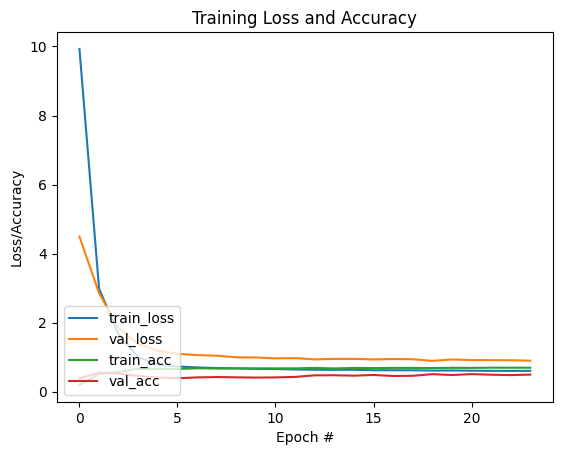

In [266]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=2, restore_best_weights=True)

# Linear model
# wandb.init(project="simclr_ojus", id="train")  # wandbは使用しないため削除

linear_model = get_linear_model(128)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

# wandbのWandbCallbackは使用しないため、callbacksから削除
history = linear_model.fit(train_features, y_train_enc,
                           validation_data=(val_features, y_val_enc),
                           batch_size=128,
                           epochs=100,
                           callbacks=[es])
plot_training(history)

In [267]:
test_images = list(paths.list_images("/workspaces/2023f_ojus/src/dataset/test"))
X_test, y_test = prepare_images(test_images)
y_test_enc = le.transform(y_test)
test_features_new = projection.predict(X_test)
test_loss, test_accuracy = linear_model.evaluate(test_features_new, y_test_enc)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

100%|██████████| 708/708 [00:02<00:00, 244.96it/s]


(708, 224, 224, 3) (708,)
23/23 [==============================] - 0s 2ms/step - loss: 0.7464 - accuracy: 0.6328
Test Loss: 0.7463852763175964
Test Accuracy: 0.6327683329582214


In [200]:
# テストデータに対する予測
y_pred = linear_model.predict(test_features_new)
y_pred_classes = np.argmax(y_pred, axis=1)


23/23 [==============================] - 0s 2ms/step


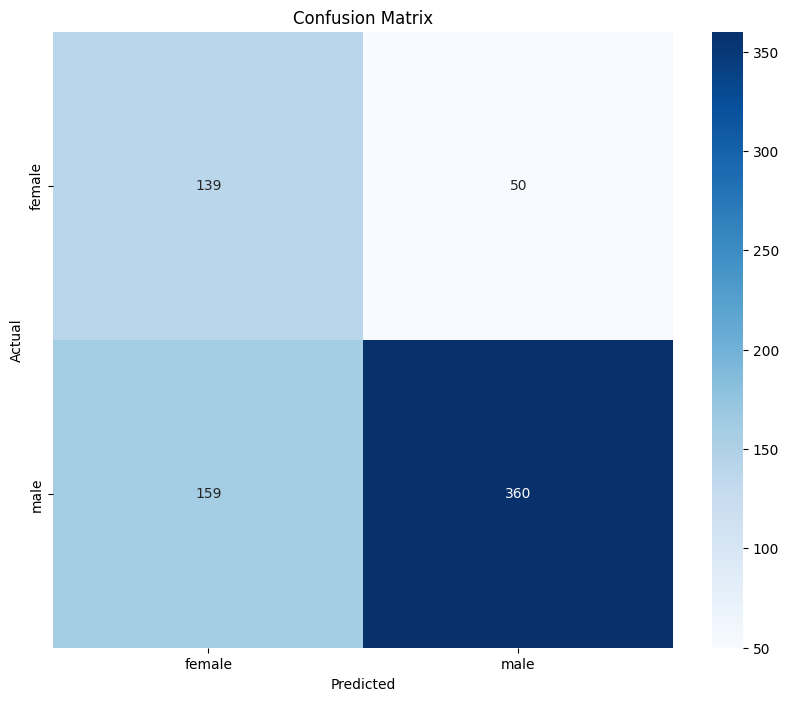

In [201]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 混同行列を計算
cm = confusion_matrix(y_pred_classes,y_test_enc)

# 混同行列をプロット
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [187]:
# y_test_encとy_pred_classesの形状を確認
print("y_test_enc shape:", y_test_enc.shape)
print("y_pred_classes shape:", y_pred_classes.shape)

# ラベル数の一致を確認
unique, counts = np.unique(y_test_enc, return_counts=True)
print("Actual distribution:", dict(zip(unique, counts)))
unique, counts = np.unique(y_pred_classes, return_counts=True)
print("Predicted distribution:", dict(zip(unique, counts)))

# テストデータのサンプル数を確認
print("Number of test images:", len(X_test))


y_test_enc shape: (708,)
y_pred_classes shape: (708,)
Actual distribution: {0: 298, 1: 410}
Predicted distribution: {0: 162, 1: 546}
Number of test images: 708


In [188]:
# 予測されたクラスのユニークな値を確認
unique, counts = np.unique(y_pred_classes, return_counts=True)
print(dict(zip(unique, counts)))


{0: 162, 1: 546}


In [142]:
print(len(test_images))

708


In [189]:
# 学習したモデルを保存
resnet_simclr.save('/workspaces/2023f_ojus/z_output/simclr_final_2.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
